In [17]:
# Imports
import numpy as np

from pandas import read_csv 

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from pyfume.Clustering import Clusterer
from pyfume.EstimateAntecendentSet import AntecedentEstimator
from pyfume.EstimateConsequentParameters import ConsequentEstimator
from pyfume.SimpfulModelBuilder import SugenoFISBuilder
from pyfume.Tester import SugenoFISTester

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, explained_variance_score

import matplotlib.pyplot as plt

In [18]:
#  Load dataset and create train-test sets
data = read_csv('data/hairdryer.csv')

In [19]:
var_names = data.columns[0:-1]

In [20]:
#data.plot(figsize=(22,3) , xlim=(0,1001) , ylim=(3.1 , 6.5) , style=['--','-'])

In [21]:
#data.plot(figsize=(22,3) , xlim=(0,100) , ylim=(3.1 , 6.5) , style=['--','-'])

In [22]:
data = data.to_numpy()

(3.1, 6.5)

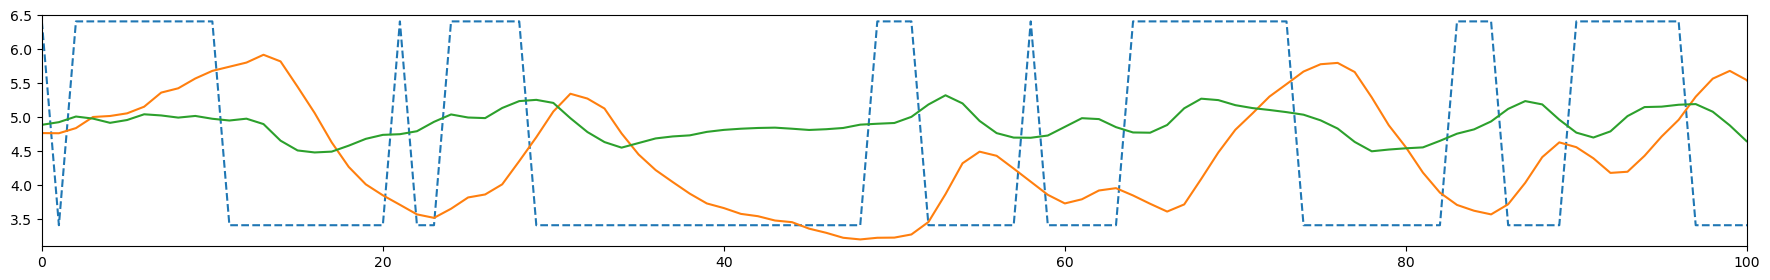

In [23]:
x_grad= np.arange(data[:,1].size)

plt.figure(figsize=(22, 3))  # Set figure size

plt.plot( x_grad ,data[:,0] , '--')
plt.plot( x_grad ,data[:,1] ,'-')
plt.plot( x_grad, np.gradient(data[:,1], x_grad)+np.mean(data[:,1]))

plt.xlim(0,100) 
plt.ylim(3.1 , 6.5)


In [24]:
# Run this cell to normalize variables
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [25]:
# train/test split
X = data[:,0:-1]
y = data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [26]:
# %% Cluster the input-output space

number_of_clusters = 2

cl = Clusterer(x_train=X_train, y_train=y_train, nr_clus=number_of_clusters)  # Number of clusters
clust_centers, part_matrix, _ = cl.cluster(method='fcm')

In [27]:
# %% Estimate membership functions parameters
ae = AntecedentEstimator(X_train, part_matrix)
antecedent_params = ae.determineMF()

In [28]:
# %% Estimate consequent parameters
ce = ConsequentEstimator(X_train, y_train, part_matrix)
conseq_params = ce.suglms()

In [29]:
# %% Build first-order Takagi-Sugeno model
modbuilder = SugenoFISBuilder(antecedent_params, conseq_params, var_names, save_simpful_code=True) #change this setting to save simpful code
model = modbuilder.get_model()

 * Detected 2 rules / clusters
 * Code saved to file Simpful_code.py
 * Detected Sugeno model type


In [30]:
# %% Get model predictions
modtester = SugenoFISTester(model, X_test, var_names)
y_pred = modtester.predict()[0]

In [31]:
# %% Compute regression metrics
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: {:.3f}".format(mse))
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error: {:.1f}%".format(mape*100))
exp_var = explained_variance_score(y_test, y_pred)
print("Explained Variance Score: {:.3f}".format(exp_var))

Mean Squared Error: 0.078
Mean Absolute Percentage Error: 71.2%
Explained Variance Score: 0.002


# Comparing settings

Fazer gráfico train error vs test error 

In [32]:


# Lists to store errors for each method
fcm_train_errors = []
fcm_test_errors = []
gk_train_errors = []
gk_test_errors = []

ncl = np.arange(2, 11)
mtd = ['fcm', 'gk']
glb_ft = [True, False]

# Capture training and test errors
for mth in mtd:
    train_errors = []
    test_errors = []
    
    for n in ncl:
        # Clustering
        cl = Clusterer(x_train=X_train, y_train=y_train, nr_clus=n)
        clust_centers, part_matrix, _ = cl.cluster(method=mth)

        # Estimate membership functions parameters
        ae = AntecedentEstimator(X_train, part_matrix)
        antecedent_params = ae.determineMF()

        # Estimate consequent parameters
        ce = ConsequentEstimator(X_train, y_train, part_matrix)
        conseq_params = ce.suglms(global_fit=True)  # Using global_fit as an example

        # Build the first-order Takagi-Sugeno model
        modbuilder = SugenoFISBuilder(antecedent_params, conseq_params, var_names, save_simpful_code=False)
        model = modbuilder.get_model()

        # Predictions on training data
        modtester_train = SugenoFISTester(model, X_train, var_names)
        y_train_pred = modtester_train.predict()[0]
        
        # Predictions on test data
        modtester_test = SugenoFISTester(model, X_test, var_names)
        y_test_pred = modtester_test.predict()[0]

        # Compute training and test errors
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)

        # Store errors for the current method and cluster count
        train_errors.append(train_mse)
        test_errors.append(test_mse)

        print(f"Method: {mth}, Clusters: {n}")
        print(f"Training MSE: {train_mse:.3f}, Test MSE: {test_mse:.3f}")
    
        # Store the results for each method separately
        if mth == 'fcm':
            fcm_train_errors= train_errors
            fcm_test_errors=test_errors
        elif mth == 'gk':
            gk_train_errors=train_errors
            gk_test_errors=test_errors




 * Detected 2 rules / clusters
 * Detected Sugeno model type
Method: fcm, Clusters: 2
Training MSE: 0.142, Test MSE: 0.136
 * Detected 3 rules / clusters
 * Detected Sugeno model type
Method: fcm, Clusters: 3
Training MSE: 3.403, Test MSE: 3.739
 * Detected 4 rules / clusters
 * Detected Sugeno model type
Method: fcm, Clusters: 4
Training MSE: 1.535, Test MSE: 1.392
 * Detected 5 rules / clusters
 * Detected Sugeno model type
Method: fcm, Clusters: 5
Training MSE: 2.741, Test MSE: 2.406
 * Detected 6 rules / clusters
 * Detected Sugeno model type
Method: fcm, Clusters: 6
Training MSE: 13.499, Test MSE: 15.367
 * Detected 7 rules / clusters
 * Detected Sugeno model type
Method: fcm, Clusters: 7
Training MSE: 37.782, Test MSE: 42.755
 * Detected 8 rules / clusters
 * Detected Sugeno model type
Method: fcm, Clusters: 8
Training MSE: 23990.783, Test MSE: 20416.882
 * Detected 9 rules / clusters
 * Detected Sugeno model type
Method: fcm, Clusters: 9
Training MSE: 26472343.544, Test MSE: 312

(0.0, 5.0)

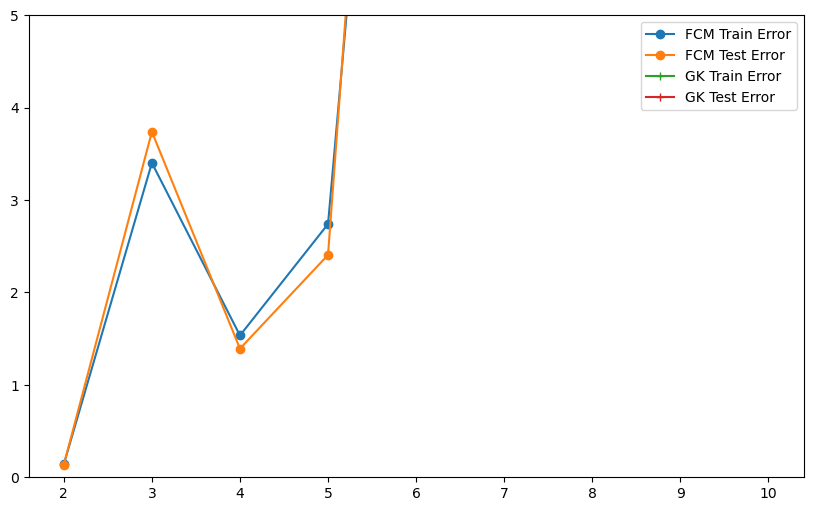

In [33]:
# Plotting the errors vs number of clusters
plt.figure(figsize=(10, 6))

# FCM method
plt.plot(ncl, fcm_train_errors, 'o-', label='FCM Train Error')
plt.plot(ncl, fcm_test_errors, 'o-', label='FCM Test Error')

# GK method
plt.plot(ncl, gk_train_errors, '+-', label='GK Train Error')
plt.plot(ncl, gk_test_errors, '+-', label='GK Test Error')

plt.legend()
plt.ylim(0, 5)

fazer gráfico com actual vs predicted values

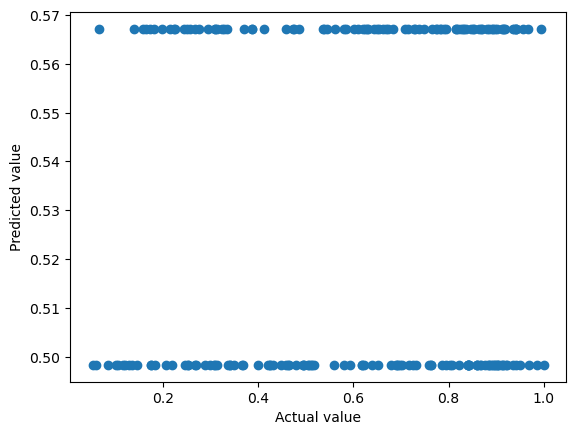

In [34]:
### Plot the actual values vs the predicted values of the test data using the matplotlib library

# this is done already on the cell above 
""""# Predict the labels of the test data
pred = model.predict_test_data()"""


"""# Get the actual labels of the test data
_, actual = modbuilder.get_data(data_set='test')
"""

# Create scatterplot
import matplotlib.pyplot as plt 
plt.scatter(y_test, y_pred)
plt.xlabel('Actual value') 
plt.ylabel('Predicted value')
#plt.plot([0,85],[0,85],'r')     # Add a reference line
plt.show()

usar K-fold CV para obter performance de cada modelo (modelos com diferentes numeros de clusters)